## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [ ]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4)
  (fc1): Linear(in_features=73728, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

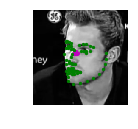

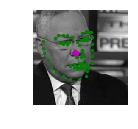

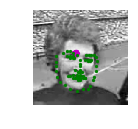

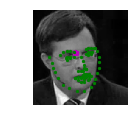

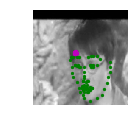

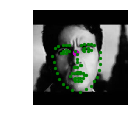

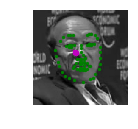

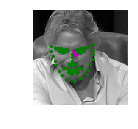

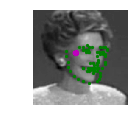

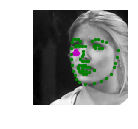

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [16]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.31534998714923856
Epoch: 1, Batch: 20, Avg. Loss: 0.20295234397053719
Epoch: 1, Batch: 30, Avg. Loss: 0.17754692435264588
Epoch: 1, Batch: 40, Avg. Loss: 0.15987954363226892
Epoch: 1, Batch: 50, Avg. Loss: 0.23712849020957946
Epoch: 1, Batch: 60, Avg. Loss: 0.19878109022974969
Epoch: 1, Batch: 70, Avg. Loss: 0.14021943807601928
Epoch: 1, Batch: 80, Avg. Loss: 0.14446860924363136
Epoch: 1, Batch: 90, Avg. Loss: 0.1831377424299717
Epoch: 1, Batch: 100, Avg. Loss: 0.12605223134160043
Epoch: 1, Batch: 110, Avg. Loss: 0.17220591902732849
Epoch: 1, Batch: 120, Avg. Loss: 0.14814935773611068
Epoch: 1, Batch: 130, Avg. Loss: 0.17375418096780776
Epoch: 1, Batch: 140, Avg. Loss: 0.14279530569911003
Epoch: 1, Batch: 150, Avg. Loss: 0.1611775390803814
Epoch: 1, Batch: 160, Avg. Loss: 0.16937032714486122
Epoch: 1, Batch: 170, Avg. Loss: 0.16175068393349648
Epoch: 1, Batch: 180, Avg. Loss: 0.1825631506741047
Epoch: 1, Batch: 190, Avg. Loss: 0.14258646741509437
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.14073850065469742
Epoch: 2, Batch: 20, Avg. Loss: 0.13466727435588838
Epoch: 2, Batch: 30, Avg. Loss: 0.13201056718826293
Epoch: 2, Batch: 40, Avg. Loss: 0.13911650851368904
Epoch: 2, Batch: 50, Avg. Loss: 0.13011860698461533
Epoch: 2, Batch: 60, Avg. Loss: 0.1465567484498024
Epoch: 2, Batch: 70, Avg. Loss: 0.18313218988478183
Epoch: 2, Batch: 80, Avg. Loss: 0.16348801217973233
Epoch: 2, Batch: 90, Avg. Loss: 0.1494025208055973
Epoch: 2, Batch: 100, Avg. Loss: 0.14839784055948257
Epoch: 2, Batch: 110, Avg. Loss: 0.15849770680069925
Epoch: 2, Batch: 120, Avg. Loss: 0.161676137894392
Epoch: 2, Batch: 130, Avg. Loss: 0.16346649155020715
Epoch: 2, Batch: 140, Avg. Loss: 0.14864209070801734
Epoch: 2, Batch: 150, Avg. Loss: 0.1484113186597824
Epoch: 2, Batch: 160, Avg. Loss: 0.15327512696385384
Epoch: 2, Batch: 170, Avg. Loss: 0.29301460534334184
Epoch: 2, Batch: 180, Avg. Loss: 0.13786369040608407
Epoch: 2, Batch: 190, Avg. Loss: 0.2044231414794922
Epoch: 2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.12344875074923038
Epoch: 3, Batch: 20, Avg. Loss: 0.14931047931313515
Epoch: 3, Batch: 30, Avg. Loss: 0.1609750472009182
Epoch: 3, Batch: 40, Avg. Loss: 0.12524463906884192
Epoch: 3, Batch: 50, Avg. Loss: 0.14804210290312766
Epoch: 3, Batch: 60, Avg. Loss: 0.15188536047935486
Epoch: 3, Batch: 70, Avg. Loss: 0.12968346513807774
Epoch: 3, Batch: 80, Avg. Loss: 0.13878472074866294
Epoch: 3, Batch: 90, Avg. Loss: 0.13339565470814704
Epoch: 3, Batch: 100, Avg. Loss: 0.1471603147685528
Epoch: 3, Batch: 110, Avg. Loss: 0.21416770964860915
Epoch: 3, Batch: 120, Avg. Loss: 0.16593252420425414
Epoch: 3, Batch: 130, Avg. Loss: 0.14097705259919166
Epoch: 3, Batch: 140, Avg. Loss: 0.16383862644433975
Epoch: 3, Batch: 150, Avg. Loss: 0.31346837878227235
Epoch: 3, Batch: 160, Avg. Loss: 0.14367823526263238
Epoch: 3, Batch: 170, Avg. Loss: 0.17062872722744943
Epoch: 3, Batch: 180, Avg. Loss: 0.12455824092030525
Epoch: 3, Batch: 190, Avg. Loss: 0.15710321217775344
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.16827699951827527
Epoch: 4, Batch: 20, Avg. Loss: 0.1596010997891426
Epoch: 4, Batch: 30, Avg. Loss: 0.12764981910586357
Epoch: 4, Batch: 40, Avg. Loss: 0.16488505750894547
Epoch: 4, Batch: 50, Avg. Loss: 0.1376644916832447
Epoch: 4, Batch: 60, Avg. Loss: 0.13693047538399697
Epoch: 4, Batch: 70, Avg. Loss: 0.12835885994136334
Epoch: 4, Batch: 80, Avg. Loss: 0.11224698051810264
Epoch: 4, Batch: 90, Avg. Loss: 0.11792891286313534
Epoch: 4, Batch: 100, Avg. Loss: 0.14469487592577934
Epoch: 4, Batch: 110, Avg. Loss: 0.21168062537908555
Epoch: 4, Batch: 120, Avg. Loss: 0.10483985915780067
Epoch: 4, Batch: 130, Avg. Loss: 0.16035501062870025
Epoch: 4, Batch: 140, Avg. Loss: 0.14464101046323777
Epoch: 4, Batch: 150, Avg. Loss: 0.13185639157891274
Epoch: 4, Batch: 160, Avg. Loss: 0.1572187803685665
Epoch: 4, Batch: 170, Avg. Loss: 0.1567287862300873
Epoch: 4, Batch: 180, Avg. Loss: 0.14622495397925378
Epoch: 4, Batch: 190, Avg. Loss: 0.12485345900058746
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.1355292670428753
Epoch: 5, Batch: 20, Avg. Loss: 0.10906713046133518
Epoch: 5, Batch: 30, Avg. Loss: 0.10952969938516617
Epoch: 5, Batch: 40, Avg. Loss: 0.09942631497979164
Epoch: 5, Batch: 50, Avg. Loss: 0.12337682656943798
Epoch: 5, Batch: 60, Avg. Loss: 0.11042358428239822
Epoch: 5, Batch: 70, Avg. Loss: 0.11215061098337173
Epoch: 5, Batch: 80, Avg. Loss: 0.11437389925122261
Epoch: 5, Batch: 90, Avg. Loss: 0.11175270527601242
Epoch: 5, Batch: 100, Avg. Loss: 0.09563512839376927
Epoch: 5, Batch: 110, Avg. Loss: 0.17368684187531472
Epoch: 5, Batch: 120, Avg. Loss: 0.12781663797795773
Epoch: 5, Batch: 130, Avg. Loss: 0.11641507223248482
Epoch: 5, Batch: 140, Avg. Loss: 0.14492318406701088
Epoch: 5, Batch: 150, Avg. Loss: 0.16252718977630137
Epoch: 5, Batch: 160, Avg. Loss: 0.13119140043854713
Epoch: 5, Batch: 170, Avg. Loss: 0.1281135082244873
Epoch: 5, Batch: 180, Avg. Loss: 0.07172329723834991
Epoch: 5, Batch: 190, Avg. Loss: 0.13996500931680203
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.12367403134703636
Epoch: 6, Batch: 20, Avg. Loss: 0.0906863421201706
Epoch: 6, Batch: 30, Avg. Loss: 0.10575751028954983
Epoch: 6, Batch: 40, Avg. Loss: 0.1052094779908657
Epoch: 6, Batch: 50, Avg. Loss: 0.09731402546167374
Epoch: 6, Batch: 60, Avg. Loss: 0.14746427424252034
Epoch: 6, Batch: 70, Avg. Loss: 0.09172419086098671
Epoch: 6, Batch: 80, Avg. Loss: 0.20905676186084748
Epoch: 6, Batch: 90, Avg. Loss: 0.10215063616633416
Epoch: 6, Batch: 100, Avg. Loss: 0.1268926426768303
Epoch: 6, Batch: 110, Avg. Loss: 0.10948930121958256
Epoch: 6, Batch: 120, Avg. Loss: 0.1514091704040766
Epoch: 6, Batch: 130, Avg. Loss: 0.10836646743118764
Epoch: 6, Batch: 140, Avg. Loss: 0.1125577598810196
Epoch: 6, Batch: 150, Avg. Loss: 0.11795486137270927
Epoch: 6, Batch: 160, Avg. Loss: 0.10093225874006748
Epoch: 6, Batch: 170, Avg. Loss: 0.13773929551243783
Epoch: 6, Batch: 180, Avg. Loss: 0.24632602334022521
Epoch: 6, Batch: 190, Avg. Loss: 0.10656237229704857
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.10849674828350545
Epoch: 7, Batch: 20, Avg. Loss: 0.08869119510054588
Epoch: 7, Batch: 30, Avg. Loss: 0.07883641645312309
Epoch: 7, Batch: 40, Avg. Loss: 0.07453315183520318
Epoch: 7, Batch: 50, Avg. Loss: 0.05296936556696892
Epoch: 7, Batch: 60, Avg. Loss: 0.06771941222250462
Epoch: 7, Batch: 70, Avg. Loss: 0.0748161643743515
Epoch: 7, Batch: 80, Avg. Loss: 0.09643708169460297
Epoch: 7, Batch: 90, Avg. Loss: 0.09787096790969371
Epoch: 7, Batch: 100, Avg. Loss: 0.10512102916836738
Epoch: 7, Batch: 110, Avg. Loss: 0.16709405556321144
Epoch: 7, Batch: 120, Avg. Loss: 0.09096519537270069
Epoch: 7, Batch: 130, Avg. Loss: 0.08329739794135094
Epoch: 7, Batch: 140, Avg. Loss: 0.10246699452400207
Epoch: 7, Batch: 150, Avg. Loss: 0.07847258038818836
Epoch: 7, Batch: 160, Avg. Loss: 0.1290070727467537
Epoch: 7, Batch: 170, Avg. Loss: 0.08852382935583591
Epoch: 7, Batch: 180, Avg. Loss: 0.0974539790302515
Epoch: 7, Batch: 190, Avg. Loss: 0.08942596428096294
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.09528113678097724
Epoch: 8, Batch: 20, Avg. Loss: 0.07890338711440563
Epoch: 8, Batch: 30, Avg. Loss: 0.09739066436886787
Epoch: 8, Batch: 40, Avg. Loss: 0.064279380813241
Epoch: 8, Batch: 50, Avg. Loss: 0.06853725984692574
Epoch: 8, Batch: 60, Avg. Loss: 0.09435238502919674
Epoch: 8, Batch: 70, Avg. Loss: 0.058853357844054696
Epoch: 8, Batch: 80, Avg. Loss: 0.05063106492161751
Epoch: 8, Batch: 90, Avg. Loss: 0.10121947154402733
Epoch: 8, Batch: 100, Avg. Loss: 0.07791615910828113
Epoch: 8, Batch: 110, Avg. Loss: 0.08074006214737892
Epoch: 8, Batch: 120, Avg. Loss: 0.08396253548562527
Epoch: 8, Batch: 130, Avg. Loss: 0.08291896060109138
Epoch: 8, Batch: 140, Avg. Loss: 0.09393132887780667
Epoch: 8, Batch: 150, Avg. Loss: 0.07189503312110901
Epoch: 8, Batch: 160, Avg. Loss: 0.07515275068581104
Epoch: 8, Batch: 170, Avg. Loss: 0.11563510224223136
Epoch: 8, Batch: 180, Avg. Loss: 0.0923205405473709
Epoch: 8, Batch: 190, Avg. Loss: 0.13110840637236834
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.10169456824660301
Epoch: 9, Batch: 20, Avg. Loss: 0.07760817669332028
Epoch: 9, Batch: 30, Avg. Loss: 0.05608755517750978
Epoch: 9, Batch: 40, Avg. Loss: 0.08790728114545346
Epoch: 9, Batch: 50, Avg. Loss: 0.054940303042531016
Epoch: 9, Batch: 60, Avg. Loss: 0.18177691325545312
Epoch: 9, Batch: 70, Avg. Loss: 0.0721537258476019
Epoch: 9, Batch: 80, Avg. Loss: 0.06925025209784508
Epoch: 9, Batch: 90, Avg. Loss: 0.057328409515321255
Epoch: 9, Batch: 100, Avg. Loss: 0.09823378957808018
Epoch: 9, Batch: 110, Avg. Loss: 0.066555430367589
Epoch: 9, Batch: 120, Avg. Loss: 0.07086916193366051
Epoch: 9, Batch: 130, Avg. Loss: 0.05794235430657864
Epoch: 9, Batch: 140, Avg. Loss: 0.11683763265609741
Epoch: 9, Batch: 150, Avg. Loss: 0.07320418935269117
Epoch: 9, Batch: 160, Avg. Loss: 0.060021452233195306
Epoch: 9, Batch: 170, Avg. Loss: 0.06140660680830479
Epoch: 9, Batch: 180, Avg. Loss: 0.08721190728247166
Epoch: 9, Batch: 190, Avg. Loss: 0.0744462851434946
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.057669323310256
Epoch: 10, Batch: 20, Avg. Loss: 0.06756827197968959
Epoch: 10, Batch: 30, Avg. Loss: 0.07285832837224007
Epoch: 10, Batch: 40, Avg. Loss: 0.048094659298658374
Epoch: 10, Batch: 50, Avg. Loss: 0.04211261160671711
Epoch: 10, Batch: 60, Avg. Loss: 0.047748958505690095
Epoch: 10, Batch: 70, Avg. Loss: 0.07534796483814717
Epoch: 10, Batch: 80, Avg. Loss: 0.053982547484338284
Epoch: 10, Batch: 90, Avg. Loss: 0.06832134313881397
Epoch: 10, Batch: 100, Avg. Loss: 0.04710749629884958
Epoch: 10, Batch: 110, Avg. Loss: 0.07799660451710225
Epoch: 10, Batch: 120, Avg. Loss: 0.11339917406439781
Epoch: 10, Batch: 130, Avg. Loss: 0.0625382199883461
Epoch: 10, Batch: 140, Avg. Loss: 0.06607070956379175
Epoch: 10, Batch: 150, Avg. Loss: 0.0672961575910449
Epoch: 10, Batch: 160, Avg. Loss: 0.09246552493423224
Epoch: 10, Batch: 170, Avg. Loss: 0.05833432450890541
Epoch: 10, Batch: 180, Avg. Loss: 0.06133654788136482
Epoch: 10, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.05045810267329216
Epoch: 11, Batch: 20, Avg. Loss: 0.10539989024400712
Epoch: 11, Batch: 30, Avg. Loss: 0.06529119238257408
Epoch: 11, Batch: 40, Avg. Loss: 0.08209878019988537
Epoch: 11, Batch: 50, Avg. Loss: 0.06055448576807976
Epoch: 11, Batch: 60, Avg. Loss: 0.07850751616060733
Epoch: 11, Batch: 70, Avg. Loss: 0.052998977899551394
Epoch: 11, Batch: 80, Avg. Loss: 0.05688698161393404
Epoch: 11, Batch: 90, Avg. Loss: 0.06887969970703126
Epoch: 11, Batch: 100, Avg. Loss: 0.06494545787572861
Epoch: 11, Batch: 110, Avg. Loss: 0.10244055427610874
Epoch: 11, Batch: 120, Avg. Loss: 0.08777939397841691
Epoch: 11, Batch: 130, Avg. Loss: 0.07906551696360112
Epoch: 11, Batch: 140, Avg. Loss: 0.08511115908622742
Epoch: 11, Batch: 150, Avg. Loss: 0.07981241121888161
Epoch: 11, Batch: 160, Avg. Loss: 0.06773118767887354
Epoch: 11, Batch: 170, Avg. Loss: 0.034234704449772835
Epoch: 11, Batch: 180, Avg. Loss: 0.06866069454699755
Epoch: 11, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.09150605350732803
Epoch: 12, Batch: 20, Avg. Loss: 0.04587096087634564
Epoch: 12, Batch: 30, Avg. Loss: 0.0617992427200079
Epoch: 12, Batch: 40, Avg. Loss: 0.06659383103251457
Epoch: 12, Batch: 50, Avg. Loss: 0.0517857626080513
Epoch: 12, Batch: 60, Avg. Loss: 0.05164240635931492
Epoch: 12, Batch: 70, Avg. Loss: 0.07249113712459802
Epoch: 12, Batch: 80, Avg. Loss: 0.05024156384170055
Epoch: 12, Batch: 90, Avg. Loss: 0.04809061586856842
Epoch: 12, Batch: 100, Avg. Loss: 0.05283656679093838
Epoch: 12, Batch: 110, Avg. Loss: 0.20316343028098344
Epoch: 12, Batch: 120, Avg. Loss: 0.06377073656767607
Epoch: 12, Batch: 130, Avg. Loss: 0.06652918625622987
Epoch: 12, Batch: 140, Avg. Loss: 0.06550024822354317
Epoch: 12, Batch: 150, Avg. Loss: 0.08497832491993904
Epoch: 12, Batch: 160, Avg. Loss: 0.04509494286030531
Epoch: 12, Batch: 170, Avg. Loss: 0.05953456480056048
Epoch: 12, Batch: 180, Avg. Loss: 0.10112146530300378
Epoch: 12, Batch: 190, Avg. Loss: 0.063

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.06012761164456606
Epoch: 13, Batch: 20, Avg. Loss: 0.1438945271074772
Epoch: 13, Batch: 30, Avg. Loss: 0.0476820869371295
Epoch: 13, Batch: 40, Avg. Loss: 0.046403674967586996
Epoch: 13, Batch: 50, Avg. Loss: 0.06567443665117026
Epoch: 13, Batch: 60, Avg. Loss: 0.03944572359323502
Epoch: 13, Batch: 70, Avg. Loss: 0.0666777877137065
Epoch: 13, Batch: 80, Avg. Loss: 0.11004948746412993
Epoch: 13, Batch: 90, Avg. Loss: 0.0724510509520769
Epoch: 13, Batch: 100, Avg. Loss: 0.04480722695589066
Epoch: 13, Batch: 110, Avg. Loss: 0.054203618504107
Epoch: 13, Batch: 120, Avg. Loss: 0.07023468278348446
Epoch: 13, Batch: 130, Avg. Loss: 0.05776655413210392
Epoch: 13, Batch: 140, Avg. Loss: 0.05489649139344692
Epoch: 13, Batch: 150, Avg. Loss: 0.10135802943259478
Epoch: 13, Batch: 160, Avg. Loss: 0.05102251097559929
Epoch: 13, Batch: 170, Avg. Loss: 0.054686822928488255
Epoch: 13, Batch: 180, Avg. Loss: 0.09533905982971191
Epoch: 13, Batch: 190, Avg. Loss: 0.05633

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.04685516580939293
Epoch: 14, Batch: 20, Avg. Loss: 0.07530673556029796
Epoch: 14, Batch: 30, Avg. Loss: 0.05049766041338444
Epoch: 14, Batch: 40, Avg. Loss: 0.05712876413017511
Epoch: 14, Batch: 50, Avg. Loss: 0.05770124606788159
Epoch: 14, Batch: 60, Avg. Loss: 0.04523602928966284
Epoch: 14, Batch: 70, Avg. Loss: 0.06657064259052277
Epoch: 14, Batch: 80, Avg. Loss: 0.05294644422829151
Epoch: 14, Batch: 90, Avg. Loss: 0.07427771110087633
Epoch: 14, Batch: 100, Avg. Loss: 0.08912460878491402
Epoch: 14, Batch: 110, Avg. Loss: 0.06033360287547111
Epoch: 14, Batch: 120, Avg. Loss: 0.05057158581912517
Epoch: 14, Batch: 130, Avg. Loss: 0.05012459438294172
Epoch: 14, Batch: 140, Avg. Loss: 0.11699369177222252
Epoch: 14, Batch: 150, Avg. Loss: 0.07208746299147606
Epoch: 14, Batch: 160, Avg. Loss: 0.04485181458294392
Epoch: 14, Batch: 170, Avg. Loss: 0.05276251547038555
Epoch: 14, Batch: 180, Avg. Loss: 0.043821399472653864
Epoch: 14, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.05866449847817421
Epoch: 15, Batch: 20, Avg. Loss: 0.038026919960975646
Epoch: 15, Batch: 30, Avg. Loss: 0.05532577261328697
Epoch: 15, Batch: 40, Avg. Loss: 0.05427930951118469
Epoch: 15, Batch: 50, Avg. Loss: 0.03251456152647734
Epoch: 15, Batch: 60, Avg. Loss: 0.03922721762210131
Epoch: 15, Batch: 70, Avg. Loss: 0.04085498880594969
Epoch: 15, Batch: 80, Avg. Loss: 0.04098744615912438
Epoch: 15, Batch: 90, Avg. Loss: 0.20709995329380035
Epoch: 15, Batch: 100, Avg. Loss: 0.056902261823415755
Epoch: 15, Batch: 110, Avg. Loss: 0.08039415646344424
Epoch: 15, Batch: 120, Avg. Loss: 0.09289763532578946
Epoch: 15, Batch: 130, Avg. Loss: 0.09227274637669325
Epoch: 15, Batch: 140, Avg. Loss: 0.042308218963444236
Epoch: 15, Batch: 150, Avg. Loss: 0.05036907028406858
Epoch: 15, Batch: 160, Avg. Loss: 0.05973753873258829
Epoch: 15, Batch: 170, Avg. Loss: 0.10528179500252008
Epoch: 15, Batch: 180, Avg. Loss: 0.07390255406498909
Epoch: 15, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.04591322299093008
Epoch: 16, Batch: 20, Avg. Loss: 0.040355063416063784
Epoch: 16, Batch: 30, Avg. Loss: 0.037495322339236734
Epoch: 16, Batch: 40, Avg. Loss: 0.050751981884241106
Epoch: 16, Batch: 50, Avg. Loss: 0.04365469999611378
Epoch: 16, Batch: 60, Avg. Loss: 0.04357580523937941
Epoch: 16, Batch: 70, Avg. Loss: 0.05119218081235886
Epoch: 16, Batch: 80, Avg. Loss: 0.04706361424177885
Epoch: 16, Batch: 90, Avg. Loss: 0.10859629418700933
Epoch: 16, Batch: 100, Avg. Loss: 0.062177032418549064
Epoch: 16, Batch: 110, Avg. Loss: 0.11657403353601695
Epoch: 16, Batch: 120, Avg. Loss: 0.04313940964639187
Epoch: 16, Batch: 130, Avg. Loss: 0.04957745764404535
Epoch: 16, Batch: 140, Avg. Loss: 0.07195320632308722
Epoch: 16, Batch: 150, Avg. Loss: 0.045496771298348906
Epoch: 16, Batch: 160, Avg. Loss: 0.049116265028715134
Epoch: 16, Batch: 170, Avg. Loss: 0.0563888356089592
Epoch: 16, Batch: 180, Avg. Loss: 0.03342913389205933
Epoch: 16, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.05301730651408434
Epoch: 17, Batch: 20, Avg. Loss: 0.07043123580515384
Epoch: 17, Batch: 30, Avg. Loss: 0.04855339378118515
Epoch: 17, Batch: 40, Avg. Loss: 0.04412479978054762
Epoch: 17, Batch: 50, Avg. Loss: 0.060078194923698904
Epoch: 17, Batch: 60, Avg. Loss: 0.06408247258514166
Epoch: 17, Batch: 70, Avg. Loss: 0.04613306894898415
Epoch: 17, Batch: 80, Avg. Loss: 0.044447993487119676
Epoch: 17, Batch: 90, Avg. Loss: 0.07256522458046674
Epoch: 17, Batch: 100, Avg. Loss: 0.040784417651593685
Epoch: 17, Batch: 110, Avg. Loss: 0.08947826586663724
Epoch: 17, Batch: 120, Avg. Loss: 0.06821015626192092
Epoch: 17, Batch: 130, Avg. Loss: 0.03734666798263788
Epoch: 17, Batch: 140, Avg. Loss: 0.04868705421686172
Epoch: 17, Batch: 150, Avg. Loss: 0.04438958987593651
Epoch: 17, Batch: 160, Avg. Loss: 0.04185107387602329
Epoch: 17, Batch: 170, Avg. Loss: 0.22523120902478694
Epoch: 17, Batch: 180, Avg. Loss: 0.04845564812421799
Epoch: 17, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.04426772724837065
Epoch: 18, Batch: 20, Avg. Loss: 0.050204722210764885
Epoch: 18, Batch: 30, Avg. Loss: 0.07787599861621856
Epoch: 18, Batch: 40, Avg. Loss: 0.058526312187314036
Epoch: 18, Batch: 50, Avg. Loss: 0.054897497221827504
Epoch: 18, Batch: 60, Avg. Loss: 0.03407382052391768
Epoch: 18, Batch: 70, Avg. Loss: 0.03689365200698376
Epoch: 18, Batch: 80, Avg. Loss: 0.04465324990451336
Epoch: 18, Batch: 90, Avg. Loss: 0.04351949989795685
Epoch: 18, Batch: 100, Avg. Loss: 0.03742173723876476
Epoch: 18, Batch: 110, Avg. Loss: 0.035524108074605466
Epoch: 18, Batch: 120, Avg. Loss: 0.0583761852234602
Epoch: 18, Batch: 130, Avg. Loss: 0.04197500497102737
Epoch: 18, Batch: 140, Avg. Loss: 0.038643525540828706
Epoch: 18, Batch: 150, Avg. Loss: 0.03923945445567369
Epoch: 18, Batch: 160, Avg. Loss: 0.03327525742352009
Epoch: 18, Batch: 170, Avg. Loss: 0.07257976513355971
Epoch: 18, Batch: 180, Avg. Loss: 0.05074020568281412
Epoch: 18, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.049869565106928346
Epoch: 19, Batch: 20, Avg. Loss: 0.06416495982557535
Epoch: 19, Batch: 30, Avg. Loss: 0.057629852741956714
Epoch: 19, Batch: 40, Avg. Loss: 0.040435143560171125
Epoch: 19, Batch: 50, Avg. Loss: 0.06078314278274775
Epoch: 19, Batch: 60, Avg. Loss: 0.0389383640140295
Epoch: 19, Batch: 70, Avg. Loss: 0.04490037560462952
Epoch: 19, Batch: 80, Avg. Loss: 0.048850680328905584
Epoch: 19, Batch: 90, Avg. Loss: 0.0522558905184269
Epoch: 19, Batch: 100, Avg. Loss: 0.05659109763801098
Epoch: 19, Batch: 110, Avg. Loss: 0.04599827695637941
Epoch: 19, Batch: 120, Avg. Loss: 0.07612550407648086
Epoch: 19, Batch: 130, Avg. Loss: 0.05367579534649849
Epoch: 19, Batch: 140, Avg. Loss: 0.039732218347489835
Epoch: 19, Batch: 150, Avg. Loss: 0.06619712114334106
Epoch: 19, Batch: 160, Avg. Loss: 0.052824320085346696
Epoch: 19, Batch: 170, Avg. Loss: 0.04373737275600433
Epoch: 19, Batch: 180, Avg. Loss: 0.06292759571224452
Epoch: 19, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.05186803601682186
Epoch: 20, Batch: 20, Avg. Loss: 0.04890203364193439
Epoch: 20, Batch: 30, Avg. Loss: 0.037162041664123534
Epoch: 20, Batch: 40, Avg. Loss: 0.04022201206535101
Epoch: 20, Batch: 50, Avg. Loss: 0.09315137006342411
Epoch: 20, Batch: 60, Avg. Loss: 0.05549254380166531
Epoch: 20, Batch: 70, Avg. Loss: 0.03754079882055521
Epoch: 20, Batch: 80, Avg. Loss: 0.06504722405225039
Epoch: 20, Batch: 90, Avg. Loss: 0.0535010039806366
Epoch: 20, Batch: 100, Avg. Loss: 0.0445883858948946
Epoch: 20, Batch: 110, Avg. Loss: 0.037103623151779175
Epoch: 20, Batch: 120, Avg. Loss: 0.040022071450948715
Epoch: 20, Batch: 130, Avg. Loss: 0.04316873848438263
Epoch: 20, Batch: 140, Avg. Loss: 0.11417092829942703
Epoch: 20, Batch: 150, Avg. Loss: 0.06828599255532027
Epoch: 20, Batch: 160, Avg. Loss: 0.11261950358748436
Epoch: 20, Batch: 170, Avg. Loss: 0.03808254580944777
Epoch: 20, Batch: 180, Avg. Loss: 0.0358482476323843
Epoch: 20, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.041099403612315656
Epoch: 21, Batch: 20, Avg. Loss: 0.04646610375493765
Epoch: 21, Batch: 30, Avg. Loss: 0.05139849055558443
Epoch: 21, Batch: 40, Avg. Loss: 0.15622111540287734
Epoch: 21, Batch: 50, Avg. Loss: 0.04760701060295105
Epoch: 21, Batch: 60, Avg. Loss: 0.043309306353330614
Epoch: 21, Batch: 70, Avg. Loss: 0.04305002111941576
Epoch: 21, Batch: 80, Avg. Loss: 0.04369937647134066
Epoch: 21, Batch: 90, Avg. Loss: 0.06574689708650112
Epoch: 21, Batch: 100, Avg. Loss: 0.043635440059006214
Epoch: 21, Batch: 110, Avg. Loss: 0.052537121996283534
Epoch: 21, Batch: 120, Avg. Loss: 0.0533062856644392
Epoch: 21, Batch: 130, Avg. Loss: 0.03235716316848993
Epoch: 21, Batch: 140, Avg. Loss: 0.03954160697758198
Epoch: 21, Batch: 150, Avg. Loss: 0.04758834801614285
Epoch: 21, Batch: 160, Avg. Loss: 0.20671393387019635
Epoch: 21, Batch: 170, Avg. Loss: 0.05787622351199388
Epoch: 21, Batch: 180, Avg. Loss: 0.08133921734988689
Epoch: 21, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.08727656658738851
Epoch: 22, Batch: 20, Avg. Loss: 0.04252687450498342
Epoch: 22, Batch: 30, Avg. Loss: 0.040528591722249985
Epoch: 22, Batch: 40, Avg. Loss: 0.03964838534593582
Epoch: 22, Batch: 50, Avg. Loss: 0.04867039639502764
Epoch: 22, Batch: 60, Avg. Loss: 0.1358675764873624
Epoch: 22, Batch: 70, Avg. Loss: 0.054826900083571675
Epoch: 22, Batch: 80, Avg. Loss: 0.04002543780952692
Epoch: 22, Batch: 90, Avg. Loss: 0.056969089061021806
Epoch: 22, Batch: 100, Avg. Loss: 0.03715525325387716
Epoch: 22, Batch: 110, Avg. Loss: 0.05216880347579718
Epoch: 22, Batch: 120, Avg. Loss: 0.07022510543465614
Epoch: 22, Batch: 130, Avg. Loss: 0.03838296439498663
Epoch: 22, Batch: 140, Avg. Loss: 0.08564483448863029
Epoch: 22, Batch: 150, Avg. Loss: 0.0467315461486578
Epoch: 22, Batch: 160, Avg. Loss: 0.03440663777291775
Epoch: 22, Batch: 170, Avg. Loss: 0.0305717209354043
Epoch: 22, Batch: 180, Avg. Loss: 0.04018778763711452
Epoch: 22, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.04200294073671103
Epoch: 23, Batch: 20, Avg. Loss: 0.03132075499743223
Epoch: 23, Batch: 30, Avg. Loss: 0.05732240807265043
Epoch: 23, Batch: 40, Avg. Loss: 0.038853414542973044
Epoch: 23, Batch: 50, Avg. Loss: 0.037293003499507905
Epoch: 23, Batch: 60, Avg. Loss: 0.029111060313880444
Epoch: 23, Batch: 70, Avg. Loss: 0.04882730394601822
Epoch: 23, Batch: 80, Avg. Loss: 0.03224642369896173
Epoch: 23, Batch: 90, Avg. Loss: 0.05923674087971449
Epoch: 23, Batch: 100, Avg. Loss: 0.08978851158171892
Epoch: 23, Batch: 110, Avg. Loss: 0.07436471953988075
Epoch: 23, Batch: 120, Avg. Loss: 0.03828349132090807
Epoch: 23, Batch: 130, Avg. Loss: 0.04357495177537203
Epoch: 23, Batch: 140, Avg. Loss: 0.037480248138308525
Epoch: 23, Batch: 150, Avg. Loss: 0.0396841861307621
Epoch: 23, Batch: 160, Avg. Loss: 0.032267413660883905
Epoch: 23, Batch: 170, Avg. Loss: 0.0705938769504428
Epoch: 23, Batch: 180, Avg. Loss: 0.05631592851132154
Epoch: 23, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.04516402594745159
Epoch: 24, Batch: 20, Avg. Loss: 0.038074635341763495
Epoch: 24, Batch: 30, Avg. Loss: 0.06127996481955052
Epoch: 24, Batch: 40, Avg. Loss: 0.06085292082279921
Epoch: 24, Batch: 50, Avg. Loss: 0.03216743003576994
Epoch: 24, Batch: 60, Avg. Loss: 0.04018076211214065
Epoch: 24, Batch: 70, Avg. Loss: 0.21475554592907428
Epoch: 24, Batch: 80, Avg. Loss: 0.13017682880163192
Epoch: 24, Batch: 90, Avg. Loss: 0.03908714782446623
Epoch: 24, Batch: 100, Avg. Loss: 0.08267152607440949
Epoch: 24, Batch: 110, Avg. Loss: 0.059213655069470406
Epoch: 24, Batch: 120, Avg. Loss: 0.033504697121679784
Epoch: 24, Batch: 130, Avg. Loss: 0.049474829249083994
Epoch: 24, Batch: 140, Avg. Loss: 0.04584674946963787
Epoch: 24, Batch: 150, Avg. Loss: 0.039884617924690245
Epoch: 24, Batch: 160, Avg. Loss: 0.0345927806571126
Epoch: 24, Batch: 170, Avg. Loss: 0.024736346490681172
Epoch: 24, Batch: 180, Avg. Loss: 0.05135291460901499
Epoch: 24, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.16068802177906036
Epoch: 25, Batch: 20, Avg. Loss: 0.03457521721720695
Epoch: 25, Batch: 30, Avg. Loss: 0.03708240333944559
Epoch: 25, Batch: 40, Avg. Loss: 0.06906233727931976
Epoch: 25, Batch: 50, Avg. Loss: 0.03521616831421852
Epoch: 25, Batch: 60, Avg. Loss: 0.037933788262307644
Epoch: 25, Batch: 70, Avg. Loss: 0.048842424713075164
Epoch: 25, Batch: 80, Avg. Loss: 0.03248225580900908
Epoch: 25, Batch: 90, Avg. Loss: 0.03815469034016132
Epoch: 25, Batch: 100, Avg. Loss: 0.046864642575383184
Epoch: 25, Batch: 110, Avg. Loss: 0.06741743814200163
Epoch: 25, Batch: 120, Avg. Loss: 0.07996738962829113
Epoch: 25, Batch: 130, Avg. Loss: 0.033365375362336636
Epoch: 25, Batch: 140, Avg. Loss: 0.03795878682285547
Epoch: 25, Batch: 150, Avg. Loss: 0.04600441232323647
Epoch: 25, Batch: 160, Avg. Loss: 0.03746228814125061
Epoch: 25, Batch: 170, Avg. Loss: 0.03073999211192131
Epoch: 25, Batch: 180, Avg. Loss: 0.04428746737539768
Epoch: 25, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.04113332778215408
Epoch: 26, Batch: 20, Avg. Loss: 0.049920056387782095
Epoch: 26, Batch: 30, Avg. Loss: 0.030851826816797257
Epoch: 26, Batch: 40, Avg. Loss: 0.04584593418985605
Epoch: 26, Batch: 50, Avg. Loss: 0.04025320503860712
Epoch: 26, Batch: 60, Avg. Loss: 0.03796237912029028
Epoch: 26, Batch: 70, Avg. Loss: 0.0428165428340435
Epoch: 26, Batch: 80, Avg. Loss: 0.045088728331029414
Epoch: 26, Batch: 90, Avg. Loss: 0.05642999596893787
Epoch: 26, Batch: 100, Avg. Loss: 0.043597721029073
Epoch: 26, Batch: 110, Avg. Loss: 0.041310885548591615
Epoch: 26, Batch: 120, Avg. Loss: 0.03197112195193767
Epoch: 26, Batch: 130, Avg. Loss: 0.060766300186514854
Epoch: 26, Batch: 140, Avg. Loss: 0.036349520087242126
Epoch: 26, Batch: 150, Avg. Loss: 0.050147329829633235
Epoch: 26, Batch: 160, Avg. Loss: 0.046494861505925654
Epoch: 26, Batch: 170, Avg. Loss: 0.055328970588743684
Epoch: 26, Batch: 180, Avg. Loss: 0.03236075472086668
Epoch: 26, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.06211056690663099
Epoch: 27, Batch: 20, Avg. Loss: 0.04512522388249636
Epoch: 27, Batch: 30, Avg. Loss: 0.03971869722008705
Epoch: 27, Batch: 40, Avg. Loss: 0.03446470387279987
Epoch: 27, Batch: 50, Avg. Loss: 0.04107237532734871
Epoch: 27, Batch: 60, Avg. Loss: 0.04436459019780159
Epoch: 27, Batch: 70, Avg. Loss: 0.046118535287678245
Epoch: 27, Batch: 80, Avg. Loss: 0.08315529953688383
Epoch: 27, Batch: 90, Avg. Loss: 0.04607319738715887
Epoch: 27, Batch: 100, Avg. Loss: 0.036734763905406
Epoch: 27, Batch: 110, Avg. Loss: 0.04006741419434547
Epoch: 27, Batch: 120, Avg. Loss: 0.04223241712898016
Epoch: 27, Batch: 130, Avg. Loss: 0.03048311360180378
Epoch: 27, Batch: 140, Avg. Loss: 0.10784719046205282
Epoch: 27, Batch: 150, Avg. Loss: 0.04229927267879248
Epoch: 27, Batch: 160, Avg. Loss: 0.02918202169239521
Epoch: 27, Batch: 170, Avg. Loss: 0.057899850979447366
Epoch: 27, Batch: 180, Avg. Loss: 0.035441786237061026
Epoch: 27, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.032815384306013586
Epoch: 28, Batch: 20, Avg. Loss: 0.04231873843818903
Epoch: 28, Batch: 30, Avg. Loss: 0.03710894994437695
Epoch: 28, Batch: 40, Avg. Loss: 0.050543969869613646
Epoch: 28, Batch: 50, Avg. Loss: 0.03293192945420742
Epoch: 28, Batch: 60, Avg. Loss: 0.03128483667969704
Epoch: 28, Batch: 70, Avg. Loss: 0.028128667175769805
Epoch: 28, Batch: 80, Avg. Loss: 0.024961611442267894
Epoch: 28, Batch: 90, Avg. Loss: 0.02885939907282591
Epoch: 28, Batch: 100, Avg. Loss: 0.0434184730052948
Epoch: 28, Batch: 110, Avg. Loss: 0.04145418517291546
Epoch: 28, Batch: 120, Avg. Loss: 0.03975623473525047
Epoch: 28, Batch: 130, Avg. Loss: 0.025934399291872978
Epoch: 28, Batch: 140, Avg. Loss: 0.024304497614502908
Epoch: 28, Batch: 150, Avg. Loss: 0.03138131555169821
Epoch: 28, Batch: 160, Avg. Loss: 0.05566212330013513
Epoch: 28, Batch: 170, Avg. Loss: 0.036245779134333134
Epoch: 28, Batch: 180, Avg. Loss: 0.052290670573711395
Epoch: 28, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.08541305921971798
Epoch: 29, Batch: 20, Avg. Loss: 0.04847033005207777
Epoch: 29, Batch: 30, Avg. Loss: 0.0532271184027195
Epoch: 29, Batch: 40, Avg. Loss: 0.053718204237520696
Epoch: 29, Batch: 50, Avg. Loss: 0.03552566133439541
Epoch: 29, Batch: 60, Avg. Loss: 0.03419722374528646
Epoch: 29, Batch: 70, Avg. Loss: 0.047647695802152154
Epoch: 29, Batch: 80, Avg. Loss: 0.04250310454517603
Epoch: 29, Batch: 90, Avg. Loss: 0.04325338322669268
Epoch: 29, Batch: 100, Avg. Loss: 0.03201677799224854
Epoch: 29, Batch: 110, Avg. Loss: 0.04328246843069792
Epoch: 29, Batch: 120, Avg. Loss: 0.040159526467323306
Epoch: 29, Batch: 130, Avg. Loss: 0.03597491849213839
Epoch: 29, Batch: 140, Avg. Loss: 0.02939404100179672
Epoch: 29, Batch: 150, Avg. Loss: 0.06607058998197317
Epoch: 29, Batch: 160, Avg. Loss: 0.10109539795666933
Epoch: 29, Batch: 170, Avg. Loss: 0.03477360960096121
Epoch: 29, Batch: 180, Avg. Loss: 0.08958075866103173
Epoch: 29, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.029000626131892204
Epoch: 30, Batch: 20, Avg. Loss: 0.053062785789370535
Epoch: 30, Batch: 30, Avg. Loss: 0.04276280999183655
Epoch: 30, Batch: 40, Avg. Loss: 0.0303006324917078
Epoch: 30, Batch: 50, Avg. Loss: 0.04278459623456001
Epoch: 30, Batch: 60, Avg. Loss: 0.03447209894657135
Epoch: 30, Batch: 70, Avg. Loss: 0.036245179176330564
Epoch: 30, Batch: 80, Avg. Loss: 0.044825964421033856
Epoch: 30, Batch: 90, Avg. Loss: 0.03840629579499364
Epoch: 30, Batch: 100, Avg. Loss: 0.033100936375558374
Epoch: 30, Batch: 110, Avg. Loss: 0.08762777633965016
Epoch: 30, Batch: 120, Avg. Loss: 0.042536919564008714
Epoch: 30, Batch: 130, Avg. Loss: 0.04772985503077507
Epoch: 30, Batch: 140, Avg. Loss: 0.052209348790347575
Epoch: 30, Batch: 150, Avg. Loss: 0.034046417102217674
Epoch: 30, Batch: 160, Avg. Loss: 0.036972542852163316
Epoch: 30, Batch: 170, Avg. Loss: 0.05672855582088232
Epoch: 30, Batch: 180, Avg. Loss: 0.10543825905770063
Epoch: 30, Batch: 190, Avg. L

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


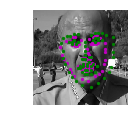

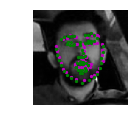

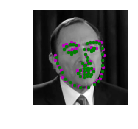

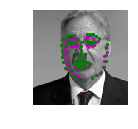

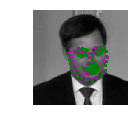

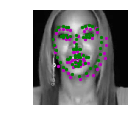

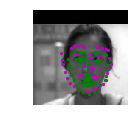

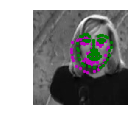

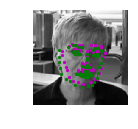

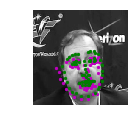

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I chose SGD with 0.01 as learning rate(lr) and 0.9 as momentum because it worked well in this case. I started with lr = 0.001 but it took longer to converse then I increased it to 0.01 and it converged pretty fast. Using SGD with momentum also helps to get out from local minima. As for loss fuction I went with mean squared loss (MSE), in our case we want actual keypoints from the model so we could not use other error functions like cross entroy as they are for classification problems.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with 2 conv layers and it was fast but convergence was not that good then i added one more conv layer and also used dropout between two linear layers for avoiding overfitting. I also tried using batch normalization but it didn't work well compared to dropout layer and thus I removed it.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: As for number of epochs, I tried with only 1 epoch to see how well the loss is decreasing, then I increased it to 5 and it worked really good. Thinking it might reduce loss pretty well, I decided to go with 30 but it took longer than I expected (about 10 hours). I should have gone with about 15 - 20 epochs as I watched the loss pretty much got reduced by then and it didn't improve any further. As for batch_size it tried increasing it as it became more slower even in 1 epoch and I let it be as 10.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.00515097  0.0011228   0.00534894 -0.02035731  0.13232914]
 [-0.19641042  0.07723285  0.18237095  0.12583984  0.15319686]
 [-0.13853113 -0.24817292  0.02543974 -0.05698704  0.03306679]
 [-0.20792028 -0.0217631  -0.10124803 -0.04738805  0.11057688]
 [-0.26535007  0.10024343  0.15363301  0.0630914   0.11097654]]
(5, 5)


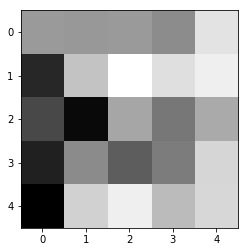

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


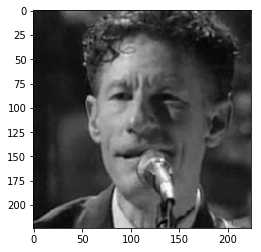

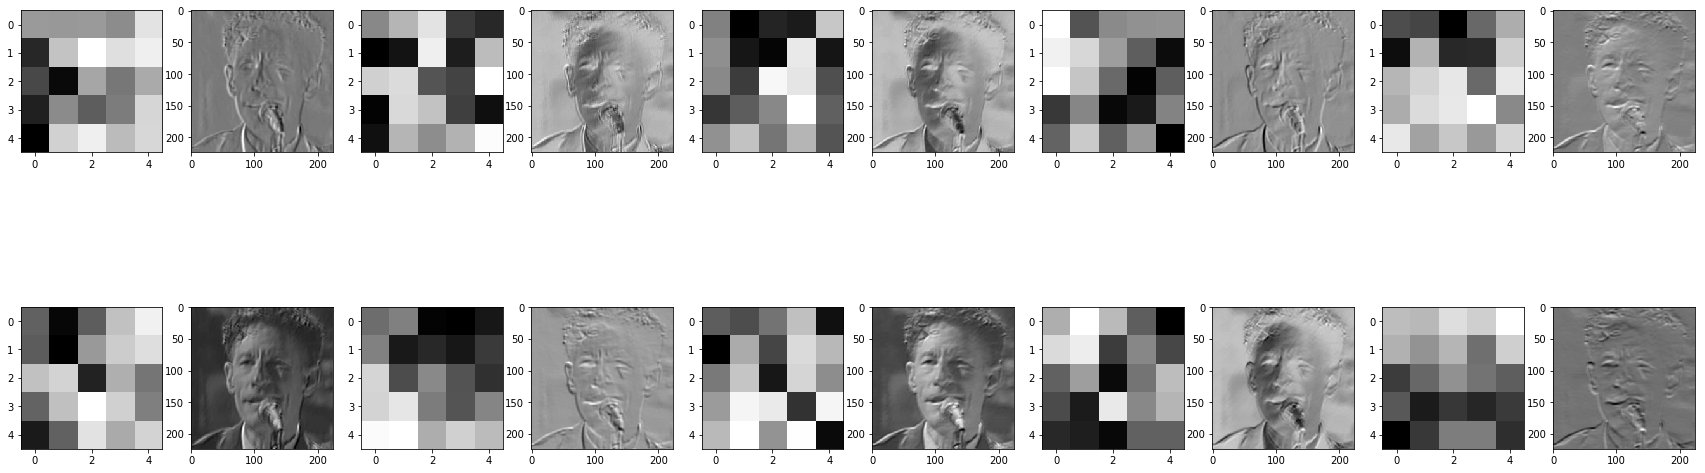

In [31]:
##TODO: load in and display any image from the transformed test dataset
dataiter = iter(test_loader)
sample = dataiter.next()
images = sample['image']
# select an image by index
idx = 8
img = np.squeeze(images[idx].numpy())

import cv2
plt.imshow(img, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The filter helps us to see what features of the image are being analysed by our CNN. Its purpose it so check whether our network is performing well or not. If we see that network is focusing on the features we are not interested on then we can find some way to remove/hide those features and then performance will surely increase. 

In my case, I tried to see the effect of couple of filters and most of them is detecting edges of face, nose, eyes and mouth and I thing its working well.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!